In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit

In [3]:
%%time
execute_CURATE()

Patient #117 has insufficient/<3 predictions (1 predictions) (for linear)!
Patient #117 has insufficient/<3 predictions (0 predictions) (for quadratic)!
Patient #121 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #126 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #130 has insufficient/<3 predictions (2 predictions) (for linear)!
Patient #130 has insufficient/<3 predictions (1 predictions) (for quadratic)!
Patient #133 has insufficient/<3 predictions (0 predictions) (for linear)!
Patient #133 has insufficient unique dose-response pairs for calibration (for quad)!
Patients to exclude for linear methods: ['117', '130', '133']
Patients to exclude for quad methods: ['117', '121', '126', '130', '133']
Wall time: 4min 9s


In [4]:
import pandas as pd
df = pd.read_excel('output_20220626-222353.xlsx', sheet_name='result')

In [5]:
from scipy import stats
from statistics import mean

dat = df.copy()

# Filter for tau methods only
dat = dat[dat.method.str.contains('tau')]

# Create patient and method list
linear_patient_list = dat[dat.method.str.contains('L_')].patient.unique().tolist()
quad_patient_list = dat[dat.method.str.contains('Q_')].patient.unique().tolist()
method_list = dat.method.unique().tolist()

# Calculate mean abs deviation by grouping by method, patient, half-life 
dat = dat.groupby(['method', 'patient', 'half_life'])['abs_deviation'].mean()
dat = dat.to_frame(name='abs_deviation').reset_index()

# # Run normality check (result p=0.0, reject normality)
# scipy.stats.kstest(dat.abs_deviation, 'norm')

# Define each fold
linear_fold_1 = linear_patient_list[0:2]
linear_fold_2 = linear_patient_list[2:4]
linear_fold_3 = linear_patient_list[4:7]
linear_fold_4 = linear_patient_list[7:10]
linear_fold_5 = linear_patient_list[10:]

quad_fold_1 = quad_patient_list[0:2]
quad_fold_2 = quad_patient_list[2:4]
quad_fold_3 = quad_patient_list[4:6]
quad_fold_4 = quad_patient_list[6:8]
quad_fold_5 = quad_patient_list[8:]

# Define each experiment
linear_exp_1_train = linear_fold_1 + linear_fold_2 + linear_fold_3 + linear_fold_4
linear_exp_2_train = linear_fold_1 + linear_fold_2 + linear_fold_3 + linear_fold_5
linear_exp_3_train = linear_fold_1 + linear_fold_2 + linear_fold_4 + linear_fold_5
linear_exp_4_train = linear_fold_1 + linear_fold_3 + linear_fold_4 + linear_fold_5
linear_exp_5_train = linear_fold_2 + linear_fold_3 + linear_fold_4 + linear_fold_5

quad_exp_1_train = quad_fold_1 + quad_fold_2 + quad_fold_3 + quad_fold_4
quad_exp_2_train = quad_fold_1 + quad_fold_2 + quad_fold_3 + quad_fold_5
quad_exp_3_train = quad_fold_1 + quad_fold_2 + quad_fold_4 + quad_fold_5
quad_exp_4_train = quad_fold_1 + quad_fold_3 + quad_fold_4 + quad_fold_5
quad_exp_5_train = quad_fold_2 + quad_fold_3 + quad_fold_4 + quad_fold_5

linear_exp_1_test = linear_fold_5
linear_exp_2_test = linear_fold_4
linear_exp_3_test = linear_fold_3
linear_exp_4_test = linear_fold_2
linear_exp_5_test = linear_fold_1

quad_exp_1_test = quad_fold_5
quad_exp_2_test = quad_fold_4
quad_exp_3_test = quad_fold_3
quad_exp_4_test = quad_fold_2
quad_exp_5_test = quad_fold_1

list_of_linear_train = [linear_exp_1_train, linear_exp_2_train, linear_exp_3_train, linear_exp_4_train, linear_exp_5_train]
list_of_quad_train = [quad_exp_1_train, quad_exp_2_train, quad_exp_3_train, quad_exp_4_train, quad_exp_5_train]
list_of_linear_test = [linear_exp_1_test, linear_exp_2_test, linear_exp_3_test, linear_exp_4_test, linear_exp_5_test]
list_of_quad_test = [quad_exp_1_test, quad_exp_2_test, quad_exp_3_test, quad_exp_4_test, quad_exp_5_test]

# Define dataframe to store results
five_fold_cross_val_results = pd.DataFrame(columns=['method', 'fold', 'train_median', 'test_median', 'pop_half_life_fold', 'indiv_pop_half_life_fold'])
five_fold_cross_val_results_summary = pd.DataFrame(columns=['method', 'train_median_mean', 'train_median_SEM', \
                                                            'test_median_mean', 'test_median_SEM', \
                                                            'pop_half_life', 'all_patient_median'])
fold_counter = 1
method_counter = 1

for method in method_list: # loop through methods
    list_of_pop_half_life_fold = []
    list_of_median_abs_dev_train = []
    list_of_median_abs_dev_test = []
    method_df = dat[dat.method == method]
    
    for i in range(5): # loop through experiments
        
        # Define train_df
        if 'L_' in method:
            train_df = method_df[method_df.patient.isin(list_of_linear_train[i])]
        else:
            train_df = method_df[method_df.patient.isin(list_of_quad_train[i])]
        
        # Find half_life at the index where abs_deviation is the lowest
        train_df.reset_index()
        pop_half_life_fold_index = train_df.index[train_df.abs_deviation == train_df.abs_deviation.min()].tolist()
        pop_half_life_fold = train_df.loc[pop_half_life_fold_index, 'half_life'].tolist()
        
        # Find median of abs_deviation among train_df with pop_half_life_fold
        median_abs_dev_train = round(train_df[train_df.half_life.isin(pop_half_life_fold)].abs_deviation.median(), 2)
        
        # Define test_df
        if 'L_' in method:
            test_df = method_df[method_df.patient.isin(list_of_linear_test[i])]
        else:
            test_df = method_df[method_df.patient.isin(list_of_quad_test[i])]
        
        # Find median of abs_deviation among test_df with pop_half_life_fold
        median_abs_dev_test = round(test_df[test_df.half_life.isin(pop_half_life_fold)].abs_deviation.median(), 2)

        # If there are multiple half-lives with the lowest abs deviation, find average of the half lives to store as pop_half_life_fold
        if len(pop_half_life_fold) > 1:
            indiv_pop_half_life_fold = pop_half_life_fold
            pop_half_life_fold = mean(pop_half_life_fold)
            pop_half_life_fold = [pop_half_life_fold]
        else: 
            pop_half_life_fold = pop_half_life_fold
            indiv_pop_half_life_fold = ""
        
        pop_half_life_fold = pop_half_life_fold[0]
        
        list_of_pop_half_life_fold.append(pop_half_life_fold)
        list_of_median_abs_dev_train.append(median_abs_dev_train)
        list_of_median_abs_dev_test.append(median_abs_dev_test)
        
        # Fill in five_fold_cross_val_results for results per fold
        five_fold_cross_val_results.loc[fold_counter, 'method'] = method
        five_fold_cross_val_results.loc[fold_counter, 'fold'] = i + 1
        five_fold_cross_val_results.loc[fold_counter, 'train_median'] = median_abs_dev_train
        five_fold_cross_val_results.loc[fold_counter, 'test_median'] = median_abs_dev_test
        five_fold_cross_val_results.loc[fold_counter, 'pop_half_life_fold'] = pop_half_life_fold
        five_fold_cross_val_results.loc[fold_counter, 'indiv_pop_half_life_fold'] = indiv_pop_half_life_fold
        
        fold_counter = fold_counter + 1
    
    # Fill in five_fold_cross_val_results_summary for results per method
    five_fold_cross_val_results_summary.loc[fold_counter, 'method'] = method
    five_fold_cross_val_results_summary.loc[fold_counter, 'train_median_mean'] = round(mean(list_of_median_abs_dev_train), 2)
    five_fold_cross_val_results_summary.loc[fold_counter, 'train_median_SEM'] = round(stats.sem(list_of_median_abs_dev_train), 2)
    five_fold_cross_val_results_summary.loc[fold_counter, 'test_median_mean'] = round(mean(list_of_median_abs_dev_test), 2)
    five_fold_cross_val_results_summary.loc[fold_counter, 'test_median_SEM'] = round(stats.sem(list_of_median_abs_dev_test), 2)
    five_fold_cross_val_results_summary.loc[fold_counter, 'pop_half_life'] = sum(list_of_pop_half_life_fold) / len(list_of_pop_half_life_fold)
    
    method_counter = method_counter + 1

five_fold_cross_val_results_summary    

,method,train_median_mean,train_median_SEM,test_median_mean,test_median_SEM,pop_half_life,all_patient_median
6,L_Cum_origin_dp_tau,2.1,0.07,2.67,0.37,3.5,NaN
11,L_Cum_origin_int_tau,2.1,0.08,2.69,0.38,3.5,NaN
16,L_Cum_wo_origin_tau,2.1,0.08,2.69,0.38,3.5,NaN
21,L_PPM_origin_dp_tau,1.78,0.04,1.87,0.16,12.5,NaN
26,L_PPM_origin_int_tau,2.27,0.03,2.23,0.1,22.74,NaN
31,L_PPM_wo_origin_tau,1.83,0.05,1.79,0.18,5.9,NaN
36,L_RW_origin_dp_tau,1.86,0.07,2.01,0.12,3.7,NaN
41,L_RW_origin_int_tau,1.83,0.03,1.89,0.11,31.5,NaN
46,L_RW_wo_origin_tau,1.83,0.03,1.89,0.11,16.033333,NaN
51,Q_Cum_origin_dp_tau,2.51,0.08,2.9,0.44,3.5,NaN


In [21]:
%%time
five_fold_cross_val_results_summary
execute_CURATE(five_fold_cross_val_results_summary)

Patient #117 has insufficient/<3 predictions (1 predictions) (for linear)!
Patient #117 has insufficient/<3 predictions (0 predictions) (for quadratic)!
Patient #121 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #126 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #130 has insufficient/<3 predictions (2 predictions) (for linear)!
Patient #130 has insufficient/<3 predictions (1 predictions) (for quadratic)!
Patient #133 has insufficient/<3 predictions (0 predictions) (for linear)!
Patient #133 has insufficient unique dose-response pairs for calibration (for quad)!
Patients to exclude for linear methods: ['117', '130', '133']
Patients to exclude for quad methods: ['117', '121', '126', '130', '133']
Wall time: 4min 39s


In [15]:
five_fold_cross_val_results_summary

,method,train_median_mean,train_median_SEM,test_median_mean,test_median_SEM,pop_half_life,all_patient_median
6,L_Cum_origin_dp_tau,2.1,0.07,2.67,0.37,3.5,NaN
11,L_Cum_origin_int_tau,2.1,0.08,2.69,0.38,3.5,NaN
16,L_Cum_wo_origin_tau,2.1,0.08,2.69,0.38,3.5,NaN
21,L_PPM_origin_dp_tau,1.78,0.04,1.87,0.16,12.5,NaN
26,L_PPM_origin_int_tau,2.27,0.03,2.23,0.1,22.74,NaN
31,L_PPM_wo_origin_tau,1.83,0.05,1.79,0.18,5.9,NaN
36,L_RW_origin_dp_tau,1.86,0.07,2.01,0.12,3.7,NaN
41,L_RW_origin_int_tau,1.83,0.03,1.89,0.11,31.5,NaN
46,L_RW_wo_origin_tau,1.83,0.03,1.89,0.11,16.033333,NaN
51,Q_Cum_origin_dp_tau,2.51,0.08,2.9,0.44,3.5,NaN


In [12]:
new_df = five_fold_cross_val_results_summary.copy()
a = float(new_df.loc[new_df.index[new_df.method == 'L_Cum_origin_dp_tau'], 'pop_half_life'])
a

3.5

In [53]:
pd.set_option('display.max_rows', None)
dat.index[dat.abs_deviation == dat[dat.method == 'L_PPM_origin_int_tau'].abs_deviation.min()]

Int64Index([2172, 2178, 2185, 2189, 2192, 2197], dtype='int64')

In [4]:
import pandas as pd
dat = pd.read_excel('output.xlsx', sheet_name='clean')

,day,response,dose,patient
0,2,2.4,0.5,84
1,3,2.8,1.0,84
2,4,3.2,1.5,84
3,5,3.1,1.5,84
4,6,7.9,3.0,84


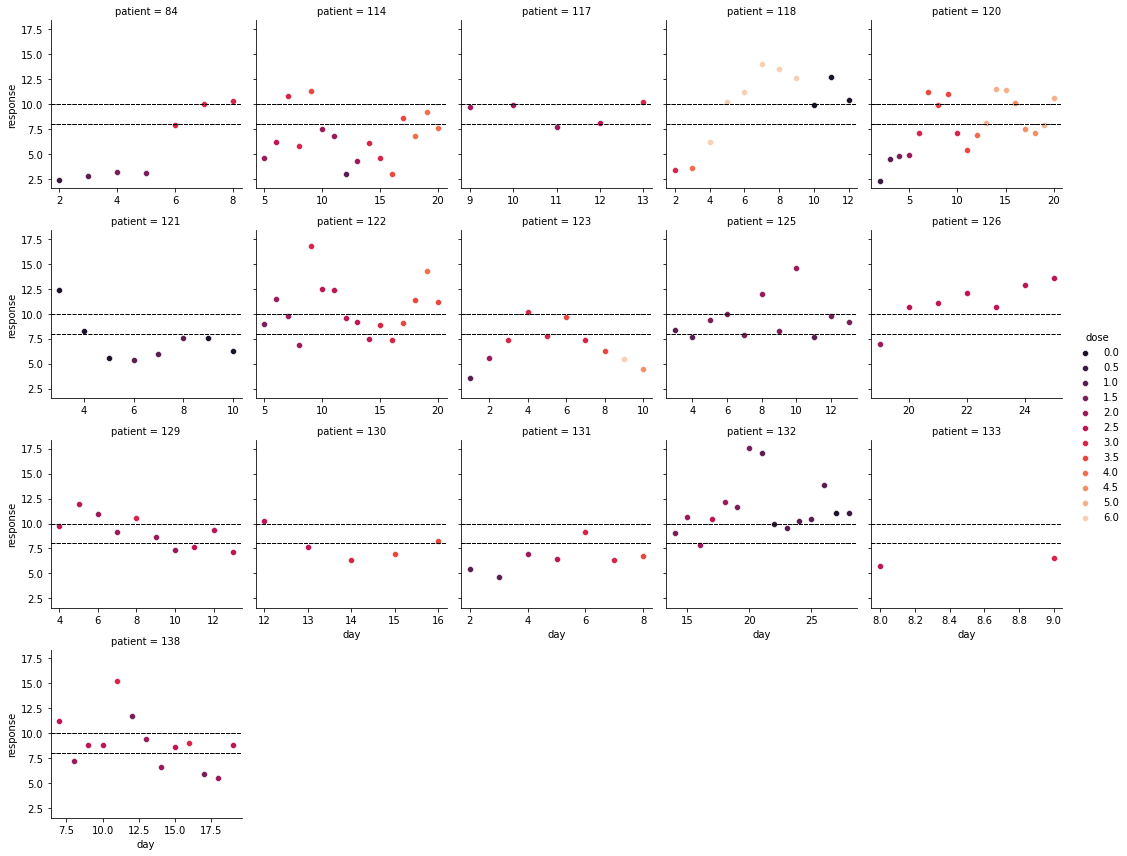

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("viridis")
dat.dose = dat.dose.astype(float)
g = sns.FacetGrid(dat, col='patient', col_wrap=5, hue='dose', palette=sns.color_palette("rocket", dat.dose.nunique()), sharex=None)
g.map_dataframe(sns.scatterplot, x='day', y='response')
# g.map_dataframe(sns.lineplot, col='black', x='day', y='response')
g.refline(y=8, color='black', lw=1, ls='--')
g.refline(y=10, color='black', lw=1, ls='--')
g.add_legend()

In [39]:
dat.head()

,day,response,dose,patient
0,2,2.4,0.5,84
1,3,2.8,1.0,84
2,4,3.2,1.5,84
3,5,3.1,1.5,84
4,6,7.9,3.0,84


In [16]:
dat.dose.dtype

dtype('float64')

In [1]:
dat = result_df.copy()
dat.head()

NameError: name 'result_df' is not defined

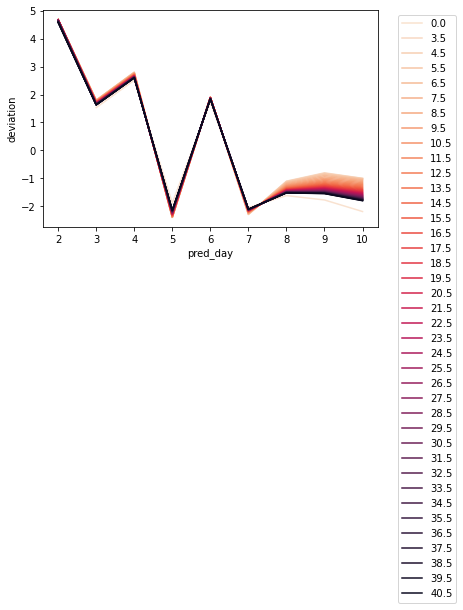

In [45]:
# How are the predictions different, between different half-lives, for each method compared to without tau?
# Plot prediction vs prediction day, for each patient, colored by tau with different half-lives vs non-tau

dat = result_df.copy()
dat = dat[['prediction', 'pred_day', 'half_life', 'method', 'patient', 'deviation']]
patient_list = dat.patient.unique()
method_list = dat.method.unique()
dat = dat[dat.patient == patient_list[6]]
dat.half_life = dat.half_life.fillna(0)
# L_Cum_origin_dp_tau
palette = sns.color_palette("rocket_r", n_colors=len(dat.half_life.unique()))
# a = np.arange(3.5, 41.5, 1)
# dat.half_life.unique()
sns.lineplot(data=dat[dat.method.str.contains("L_RW_origin_dp")], 
             x="pred_day", y="deviation", hue="half_life", 
             palette=palette, ci=None)
plt.legend(bbox_to_anchor=(1.25,1), loc='upper right')
# plt.plot(data=dat[dat.method == "L_Cum_origin_dp_tau"], 
#          x="pred_day", y="prediction", color="half_life".map())

In [ ]:
dat = result_df.copy()
dat = dat[['deviation', 'method', 'patient', 'pred_day', 'response', 'prediction', 'half_life']]
dat['half_life'] = dat['half_life'].fillna('')
dat = dat.loc[(dat.method == 'Q_Cum_origin_dp_tau') | (dat.method == 'Q_Cum_origin_dp')]
dat['new_method'] = ""
for i in range(len(dat)):
    dat['new_method'].iloc[i] = dat['method'].iloc[i] + '_' + str(dat['half_life'].iloc[i])
    # print(dat['method'].iloc[i])
plot = sns.lineplot(data=dat, x="patient", y="deviation", hue="new_method", ci=None, legend=False)
plot = sns.lineplot(data=dat.loc[dat.method=='Q_Cum_origin_dp_ '], x="patient", y="deviation", color='b', ci=None, legend=False)
# dat.head()

# sns.lineplot(data=dat.loc[dat.patient==84], x="pred_day", y="deviation", hue="method")

# dat

In [ ]:
# Plotting
# perc_days_within_target_tac(result_df)
# perc_days_outside_target_tac(result_df)
# median_perc_within_acc_dev(result_df)
# can_benefit(result_df)
# modified_TTR(result_df)
# wrong_range(result_df)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

d = {'dose': [0.5, 1, 1.5, 1.5, 3, 3], 'response': [2.4, 2.8, 3.2, 3.1, 7.9, 10]}
df = pd.DataFrame(data=d)

# Calculate weight
j = 0
decay_weight = []
for i in range(len(df)):
    decay_weight.append(math.exp(-(24*(i))/(12/np.log(2))))

# Fit model
poly_reg = PolynomialFeatures(degree=2)
X = np.array(df.dose).reshape(-1, 1)
y = np.array(df.response)
X = poly_reg.fit_transform(X)
result = LinearRegression(fit_intercept=False).fit(X, y, decay_weight)
result.coef_
# new = 3
# prediction = result.predict(poly_reg.fit_transform([[new]]))[0]
# prediction

In [ ]:
np.array(3).reshape(-1, 1)

In [8]:
a = pd.DataFrame(columns=['col1','col2'])
a = a[0:0]
a.loc[2, :] = [1, 2]

b = pd.DataFrame(columns=['col1','col2'])
b = b[0:0]
b.loc[0, :] = [1, 2]
b.loc[1, :] = [1, 2]

pd.concat([a, b])

,col1,col2
2,1,2
0,1,2
1,1,2
